# Djokovic ML model

Here we want to analyze Djokovic's data and use ML to predict some stats. We choose Djokovic because he has the highest number of played matches (= more data) 

In [265]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt

In [266]:
conn = sqlite3.connect('../data.db')
df = pd.read_sql_query("SELECT * FROM djokovic ORDER BY win", conn) # select all Djokovic's matches
print(df.columns)
print(df.dtypes)

Index(['id', 'tourney_name', 'surface', 'tourney_date', 'best_of', 'minutes',
       'tot_games', 'round', 'ace', 'df', 'firstWon', 'firstIn', 'win', 'rank',
       'serve_games', 'serve_points', 'opponent', 'opponent_ace',
       'opponent_df', 'opponent_firstWon', 'opponent_firstIn', 'opponent_rank',
       'opponent_serve_games', 'opponent_serve_points', 'opponent_hand',
       'opponent_height'],
      dtype='object')
id                         int64
tourney_name              object
surface                   object
tourney_date              object
best_of                    int64
minutes                  float64
tot_games                float64
round                     object
ace                      float64
df                       float64
firstWon                 float64
firstIn                  float64
win                       object
rank                     float64
serve_games              float64
serve_points             float64
opponent                  object
opponent_ace 

In [267]:
from IPython.core.display import display, HTML

# Generate HTML table
def display_scrollable_table(df):
    html = f"""
    <style>
        .dataframe-container {{
            max-height: 500px;
            overflow-y: scroll;
            border: 1px solid #ccc;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
        }}
        th, td {{
            padding: 8px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }}
        thead th {{
            position: sticky;
            top: 0;
            background: white;
            z-index: 2;
        }}
    </style>
    <div class="dataframe-container">
        {df.to_html(index=False)}
    </div>
    """
    display(HTML(html))

# Display table
display_scrollable_table(df)

/tmp/ipykernel_11370/2400204458.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


id,tourney_name,surface,tourney_date,best_of,minutes,tot_games,round,ace,df,firstWon,firstIn,win,rank,serve_games,serve_points,opponent,opponent_ace,opponent_df,opponent_firstWon,opponent_firstIn,opponent_rank,opponent_serve_games,opponent_serve_points,opponent_hand,opponent_height
4,Australian Open,Hard,20180115.0,5,201.0,36.0,R16,2.0,9.0,53.0,81.0,no,14.0,18.0,130.0,Hyeon Chung,1.0,2.0,59.0,91.0,58.0,18.0,136.0,R,188.0
5,Indian Wells Masters,Hard,20180305.0,3,150.0,29.0,R64,4.0,4.0,39.0,60.0,no,13.0,14.0,94.0,Taro Daniel,1.0,8.0,37.0,52.0,109.0,15.0,107.0,R,191.0
6,Miami Masters,Hard,20180319.0,3,67.0,19.0,R64,2.0,3.0,18.0,34.0,no,12.0,10.0,55.0,Benoit Paire,9.0,2.0,24.0,32.0,47.0,9.0,48.0,R,196.0
9,Monte Carlo Masters,Clay,20180416.0,3,149.0,29.0,R16,3.0,2.0,46.0,72.0,no,13.0,15.0,114.0,Dominic Thiem,9.0,5.0,38.0,51.0,7.0,14.0,95.0,R,185.0
10,Barcelona,Clay,20180423.0,3,99.0,24.0,R32,5.0,2.0,34.0,48.0,no,12.0,12.0,61.0,Martin Klizan,4.0,4.0,28.0,42.0,140.0,12.0,67.0,L,190.0
12,Madrid Masters,Clay,20180507.0,3,102.0,26.0,R32,2.0,2.0,33.0,48.0,no,12.0,13.0,67.0,Kyle Edmund,5.0,2.0,31.0,45.0,22.0,13.0,71.0,R,188.0
17,Rome Masters,Clay,20180514.0,3,116.0,21.0,SF,4.0,0.0,27.0,45.0,no,18.0,11.0,63.0,Rafael Nadal,1.0,2.0,25.0,39.0,2.0,10.0,65.0,L,185.0
22,Roland Garros,Clay,20180528.0,5,206.0,40.0,QF,5.0,2.0,57.0,87.0,no,22.0,20.0,127.0,Marco Cecchinato,6.0,5.0,73.0,117.0,72.0,20.0,157.0,R,185.0
27,Queen's Club,Grass,20180618.0,3,177.0,33.0,F,12.0,5.0,62.0,81.0,no,22.0,16.0,109.0,Marin Cilic,18.0,6.0,46.0,54.0,6.0,17.0,113.0,R,198.0
37,Canada Masters,Hard,20180806.0,3,137.0,30.0,R16,11.0,4.0,41.0,56.0,no,10.0,14.0,97.0,Stefanos Tsitsipas,11.0,2.0,46.0,55.0,27.0,16.0,92.0,R,193.0


We have to encode the date in some way. Here I chose to store only the year and the month of the match, and I encoded the month as a cyclical feature (December close to January). Other choices are possibile: for example one could consider one unique monotonic feature such as date = year*12 + month

In [268]:
from feature_engine.creation import CyclicalFeatures

# Separate year from month
yyyy, mm = [[], []]
for el in df["tourney_date"]:
    yyyy.append(int(el[:4]))
    mm.append(int(el[4:6]))
df_date = pd.DataFrame({"year": yyyy, "month": mm})
# Convert to cyclical feature
cyclical = CyclicalFeatures(variables=None, drop_original=True)
df_date = cyclical.fit_transform(df_date)
# Merge into dataframe
df = df.drop("tourney_date", axis=1)
df = pd.concat([df, df_date], axis=1)

Now we want to create data pipelines. I decided to make three different pipelines: A) numerical data, B) categorical data  
- numerical data -> replace NaN with mean value -> scale to zero mean unit variance distribution  
- categorical data -> replace NaN with category "missing" -> onehot encoding

In [269]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [270]:
from sklearn.compose import ColumnTransformer


# Split data into categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Remove target variable from categorical columns
categorical_columns = categorical_columns.drop('win')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)])

# Apply the pipeline to your dataset
X = df.drop('win', axis=1)
encoded_y = []
for el in df['win']:
    if "yes" in el:
        encoded_y.append(1)
    else:
        encoded_y.append(0)
y = pd.DataFrame({"win": encoded_y}) # dependent variable 
X_preprocessed = pipeline.fit_transform(X)
print(y)

      win
0       0
1       0
2       0
3       0
4       0
...   ...
2827    1
2828    1
2829    1
2830    1
2831    1

[2832 rows x 1 columns]


In [271]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

models = {
    'SVM': SVC(random_state=29),
    'Logistic': LogisticRegression(random_state=4),
    'Tree': DecisionTreeClassifier(random_state=99)
}

# Define the hyperparameter grids for each model
param_grids = {
    'SVM': {
        'kernel' : ['linear', 'poly', 'sigmoid',]
    },
    'Logistic': {
        'solver': ['liblinear', 'newton-cholesky', 'saga'],
    },
    'Tree': {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [30, 50, None],
    }
}

In [272]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [273]:
# Train and tune the models
from sklearn.model_selection import GridSearchCV

grids = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring='accuracy', n_jobs=-1, verbose=2)
    grids[model_name].fit(X_train, y_train.values.ravel())
    best_params = grids[model_name].best_params_
    best_score = grids[model_name].best_score_
    
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best accuracy for {model_name}: {best_score}\n')

counts = y_test.value_counts()
print(counts[1] / (counts[0] + counts[1]))

In [274]:
for model_name, model in models.items():
    print(f'Testing {model_name}...')
    sc = grids[model_name].score(X_test, y_test.values.ravel())
    print(sc)



for a,b in zip(X_test, y_test.values):
    #print(b)
    print(grids["Tree"].predict(a), b)

SVM
Logistic
Tree


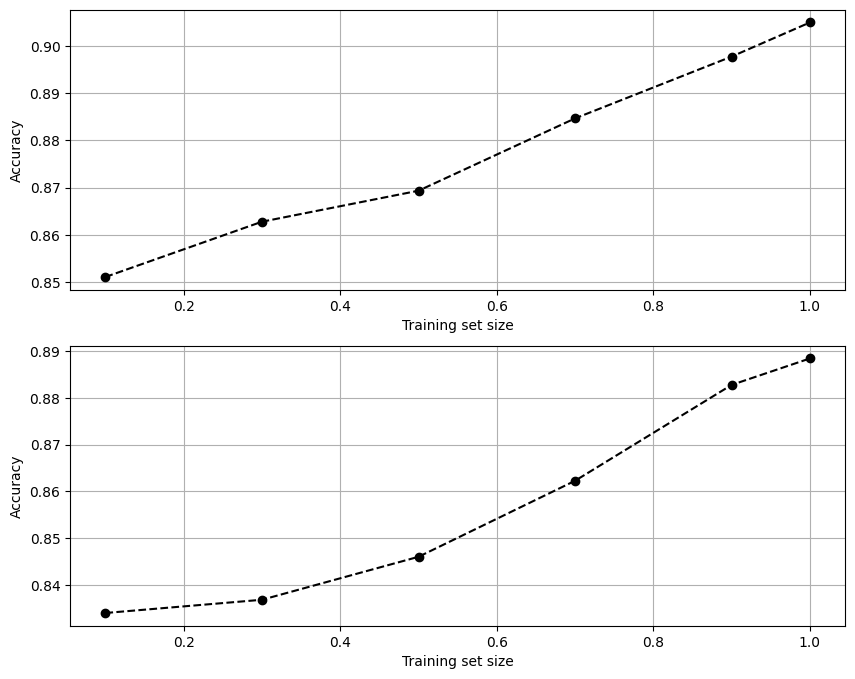

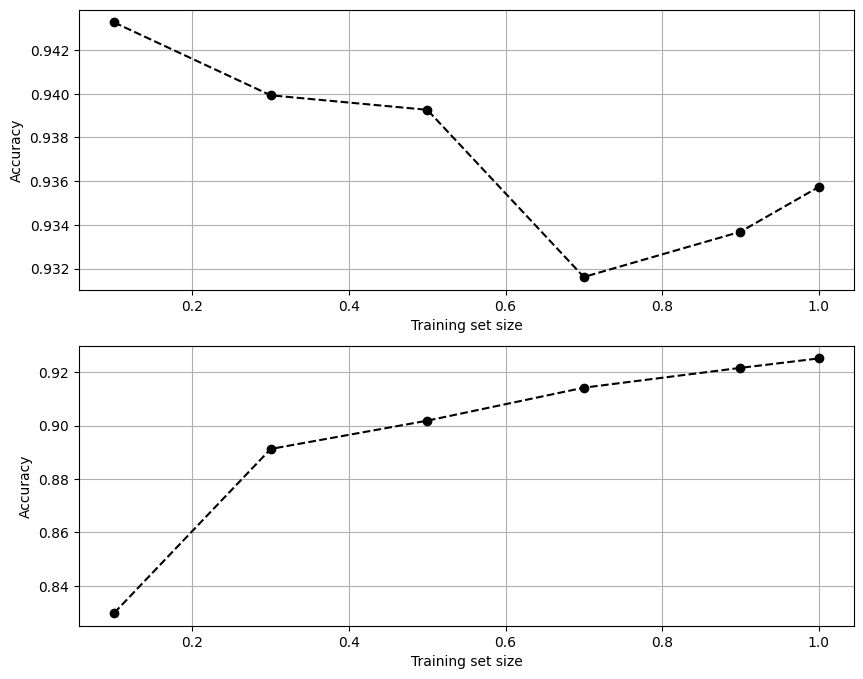

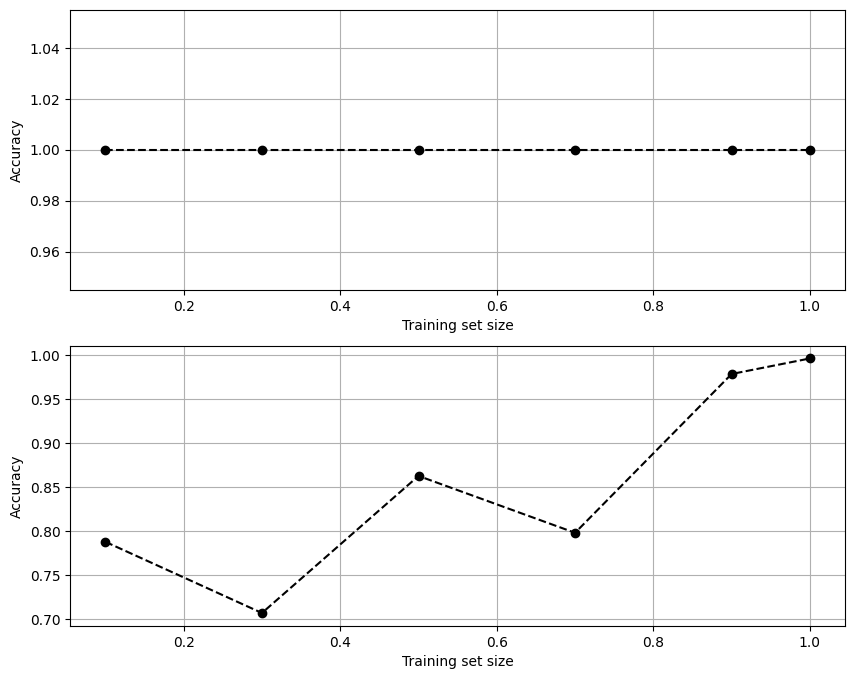

In [275]:
# from sklearn.model_selection import learning_curve
# import numpy as np 
# train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
# for model_name, model in models.items():
#     print(model_name)
#     _, train_scores, test_scores = learning_curve(model, X=X_preprocessed, y=y.values.ravel(), 
#                                                   train_sizes=train_sizes, error_score="raise", scoring="accuracy", 
#                                                   shuffle=True, n_jobs=-1, random_state=1, cv=3)
#     fig, axes = plt.subplots(2, 1, figsize=(10, 8))
#     axes[0].plot(train_sizes, np.average(train_scores, axis=1), 'o--', color="black")
#     axes[0].grid()
#     axes[0].set_xlabel("Training set size")
#     axes[0].set_ylabel("Accuracy")
#     axes[1].plot(train_sizes, np.average(test_scores, axis=1), 'o--', color="black")
#     axes[1].grid()
#     axes[1].set_xlabel("Training set size")
#     axes[1].set_ylabel("Accuracy")
#     plt.savefig(f"{model_name}.pdf")
        
    